## Rover Project Test Notebook
<b> Note this notebook was mainly used for testing. Please see the other python files included in the same directory as this file for updated code and more comments </b>


This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!


## Imports/Notebook Config:

In [1]:
%matplotlib inline

# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()


## Quick Look at the Data
Next, read in and display a random image from the test dataset folder. <b>Note</b>, you must change this path to your test dataset folder.

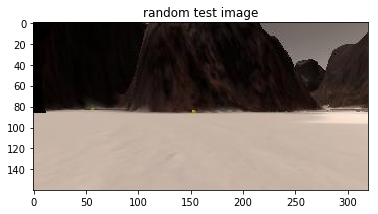

In [2]:
path = '../../recorded-data/IMG/*'

img_list = glob.glob(path)
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)
plt.title('random test image')
plt.show()

## Define Our Calibration Model
Read in and display example grid and rock sample calibration images. 

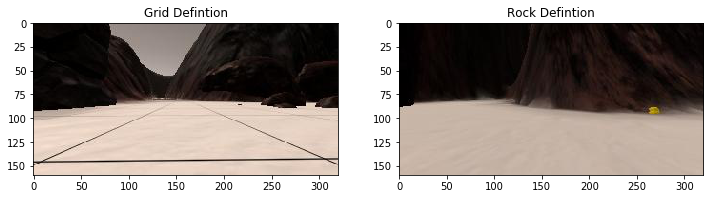

In [3]:
example_grid = '../calibration_images/grid.jpg'
example_rock = '../calibration_images/rock_2.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.title("Grid Defintion")
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)
plt.title("Rock Defintion")
plt.show()

## Perspective Transform

First, get grid points for transform from interactive matplotlib graph:

From the below graph we get:

BL: [6.7,145.5] <br>
BR: [306.1, 142.7]<br>
TR: [ 197.7, 96.8]<br>
TL: [118.2, 96.7]<br>

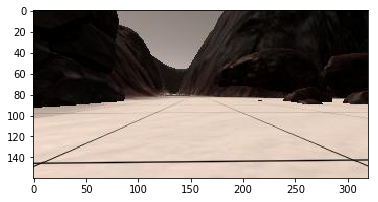

In [4]:
#%matplotlib notebook #make interactive
%matplotlib inline
plt.imshow(grid_img)
plt.show()

Define the perspective transform function and test it on an image.

Text(0.5,1,'Top down rover-warped perspective')

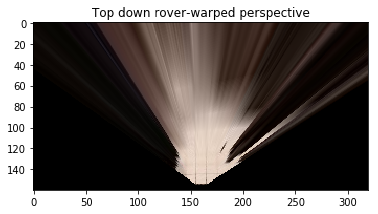

In [5]:
%matplotlib inline
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# We are mapping from 1 meter squared boxes in the rovers perspective to
# a 10x10 pixel box in the top-down view space
dst_size = 10 
# The rover is slightly offset from the actual image. Account with bottom_offset:
bottom_offset = 6


#Source values gathered above
source = np.float32([[6.7,145.5], 
                     [306.1, 142.7],
                     [ 197.7, 96.8], 
                     [118.2, 96.7]])

#map rover perspective to bottom middle of top down view:
img_w = image.shape[1]
img_h = image.shape[0]

destination = np.float32([[img_w/2 - dst_size/2, img_h - bottom_offset],
                  [img_w/2 + dst_size/2, img_h - bottom_offset],
                  [img_w/2 + dst_size/2, img_h - dst_size - bottom_offset], 
                  [img_w/2 - dst_size/2, img_h - dst_size - bottom_offset],
                  ])

warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
plt.title("Top down rover-warped perspective")
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function, find rocks and obstacles

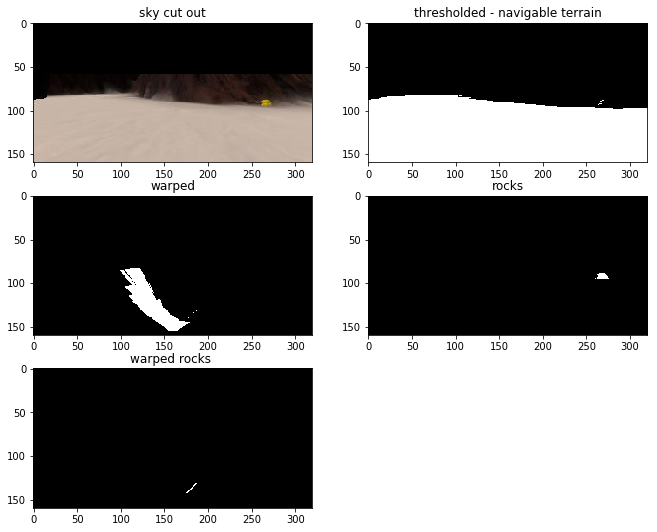

In [6]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def bw_thresh(img, bw_threshold_value = 150):
    
    #convert to black and white with opencv
    img_bw = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Create an array of zeros same xy size as img
    color_select = np.zeros_like(img)
    
    #mask based on threshold
    mask = img_bw >= bw_threshold_value
    
    # Index the array of zeros with the boolean array and set to 1
    color_select[mask] = [1,1,1]
    color_select[~mask] = [0,0,0]
    # Return the binary image
    return color_select

#cut out sky
def cut_top_of_colored_image(img, pixels_to_cut=60):
    cut_img = np.copy(img)
    cut_img[:pixels_to_cut,:] = [0,0,0]
    return cut_img

def rock_thresh(img):
    rocks = np.copy(img)
    
    #filter out walls
    mask = bw_thresh(img, 90) < 1
    
    rocks[mask] = 0
    
    #filter out ground  - use hsv values
    rocks = cv2.cvtColor(rocks, cv2.COLOR_BGR2HSV)
    mask = rocks[:,:,1] > 100
    
    rocks[~mask] = [0,0,0]
    rocks[mask]=[1,1,1]
    
    return rocks

test_image = np.copy(rock_img)

#cut out the sky
cut_img = cut_top_of_colored_image(test_image)

plt.figure(figsize=(11,9))
plt.subplot(3,2,1)
plt.title("sky cut out")
plt.imshow(cut_img)

#threshold to get navigable terrain
threshed = bw_thresh(cut_img)
plt.subplot(3,2,2)
plt.title("thresholded - navigable terrain")
plt.imshow(threshed[:,:,0], cmap = "gray")

#warp cut image
warped = perspect_transform(threshed, source, destination)
plt.subplot(3,2,3)
plt.title("warped")
plt.imshow(warped[:,:,0], cmap = "gray")

#get rocks
rocks_rover_perspect = rock_thresh(cut_img)
plt.subplot(3,2,4)
plt.title("rocks")
plt.imshow(rocks_rover_perspect[:,:,0], cmap = "gray")

warped_rocks = perspect_transform(rocks_rover_perspect, source, destination)
plt.subplot(3,2,5)
plt.title("warped rocks ")
plt.imshow(warped_rocks[:,:,0], cmap = "gray")


#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

plt.show()





## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

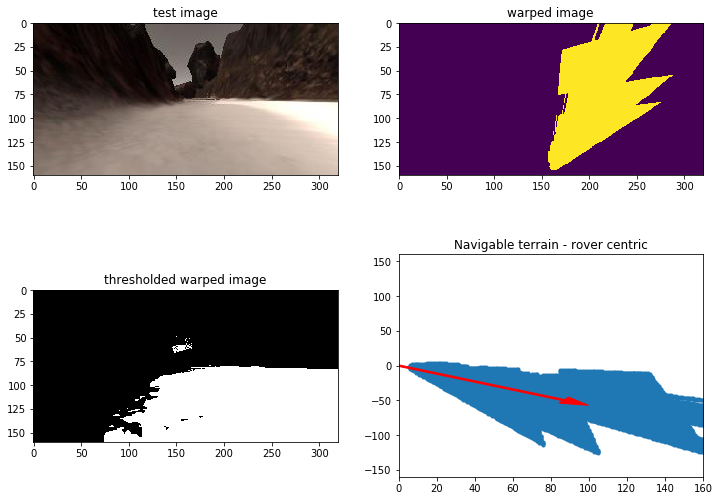

In [7]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
threshed = bw_thresh(image)
warped = perspect_transform(threshed, source, destination)
warped = warped[:,:,0]
threshed = threshed[:,:,0]

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(warped)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.title("test image")
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.title("warped image")
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.title("thresholded warped image")
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.title("Navigable terrain - rover centric")
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.show()


In [8]:
def get_rock_world_coordinates(img, source, destination,xpos,ypos,yaw,world_size,scale):
    rover_perspect = np.copy(img)
    rover_perspect= cut_top_of_colored_image(rover_perspect)
    threshed = rock_thresh(rover_perspect)
    top_down = perspect_transform(threshed, source, destination)
    
    top_down = top_down[:,:,0]
    threshed = threshed[:,:,0]
    xpix, ypix = rover_coords(top_down)
    
    
    #filter distances too far
    pix_mask = xpix**2+ypix**2 <= 80**2
    xpix=xpix[pix_mask] 
    ypix=ypix[pix_mask] 
    
    #filter distances angles outside of 15deg
    pix_mask = (np.arctan2(ypix,xpix)*180/np.pi)**2 < 30**2
    xpix=xpix[pix_mask] 
    ypix=ypix[pix_mask] 
    '''
    plt.imshow(rover_perspect)
    plt.show()
    plt.imshow(threshed)
    plt.show()
    plt.imshow(top_down)
    plt.show()
    plt.plot(xpix,ypix, ".")
    plt.ylim(-160, 160)
    plt.xlim(0, 160)
    plt.show()
    '''
    
    return pix_to_world(xpix,ypix,xpos,ypos,yaw,world_size,scale)

def get_obstacle_world_coordinates(img, source, destination,xpos,ypos,yaw,world_size,scale):
    threshed = bw_thresh(img)
    warped = perspect_transform(threshed, source, destination)
    warped = warped[:,:,0]
    threshed = threshed[:,:,0]
    mask = threshed > 0
    threshed = np.ones_like(threshed)
    threshed[mask]=0
    threshed = perspect_transform(threshed, source, destination)
    xpix, ypix = rover_coords(threshed)
    pix_mask = xpix**2+ypix**2 >= 80**2
    xpix[pix_mask] = 0
    ypix[pix_mask] = 0
    
    #filter distances angles outside of 15deg
    pix_mask = (np.arctan2(ypix,xpix)*180/np.pi)**2 > 30**2
    xpix[pix_mask] = 0
    ypix[pix_mask] = 0
    '''
    plt.imshow(img)
    plt.show()
    plt.imshow(threshed)
    plt.show()
    plt.imshow(warped)
    plt.show()
    plt.plot(xpix,ypix, ".")
    plt.ylim(-160, 160)
    plt.xlim(0, 160)
    plt.show()
    '''
    return pix_to_world(xpix,ypix,xpos,ypos,yaw,world_size,scale)

def get_navigible_terrain_world_coordinates(img, source, destination,xpos,ypos,yaw,world_size,scale):
    threshed = bw_thresh(cut_top_of_colored_image(img))
    warped = perspect_transform(threshed, source, destination)
    warped = warped[:,:,0]
    threshed = threshed[:,:,0]
    xpix, ypix = rover_coords(warped)
    #filter distances too far
    pix_mask = xpix**2+ypix**2 >= 80**2
    xpix[pix_mask] = 0
    ypix[pix_mask] = 0
    
    #filter distances angles outside of 15deg
    pix_mask = (np.arctan2(ypix,xpix)*180/np.pi)**2 > 30**2
    xpix[pix_mask] = 0
    ypix[pix_mask] = 0
    '''
    plt.imshow(img)
    plt.show()
    plt.imshow(threshed)
    plt.show()
    plt.imshow(warped)
    plt.show()
    plt.plot(xpix,ypix, ".")
    plt.ylim(-160, 160)
    plt.xlim(0, 160)
    plt.show()
    '''
    xpix_w, ypix_w = pix_to_world(xpix,ypix,xpos,ypos,yaw,world_size,scale)
    return xpix_w, ypix_w, threshed

#get_obstacle_world_coordinates(rock_img,source, destination,0,0,0,0,0)
#get_navigible_terrain_world_coordinates(rock_img,source, destination,0,0,0,0,0)
get_rock_world_coordinates(rock_img,source, destination,0,0,0,0,0)

(array([], dtype=int32), array([], dtype=int32))

## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [9]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../../recorded-data/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [10]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    #print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
        #edit later, should only be done once to find M
    
    dst_size = 10 
    bottom_offset = 6

    #Source values gathered above
    source = np.float32([[6.7,145.5], 
                         [306.1, 142.7],
                         [ 197.7, 96.8], 
                         [118.2, 96.7]])

    #map rover perspective to bottom middle of top down view:
    img_w = image.shape[1]
    img_h = image.shape[0]

    destination = np.float32([[img_w/2 - dst_size/2, img_h - bottom_offset],
                  [img_w/2 + dst_size/2, img_h - bottom_offset],
                  [img_w/2 + dst_size/2, img_h - dst_size - bottom_offset], 
                  [img_w/2 - dst_size/2, img_h - dst_size - bottom_offset],
                  ])
    
    # 2) Apply perspective transform
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Convert thresholded image pixel values to rover-centric coords
    # 5) Convert rover-centric pixel values to world coords
    
    navigable_x_world,navigable_y_world, threshed = get_navigible_terrain_world_coordinates(np.copy(img),\
                                                                                  source, \
                                                                                  destination,\
                                                                                  data.xpos[data.count],\
                                                                                  data.ypos[data.count],\
                                                                                  data.yaw[data.count],\
                                                                                  200,\
                                                                                  10)

    rock_x_world, rock_y_world = get_rock_world_coordinates(np.copy(img),\
                                                          source, \
                                                          destination,\
                                                          data.xpos[data.count],\
                                                          data.ypos[data.count],\
                                                          data.yaw[data.count],\
                                                          200,\
                                                          10)
    
    obstacle_x_world, obstacle_y_world = get_obstacle_world_coordinates(np.copy(img),\
                                                                      source, \
                                                                      destination,\
                                                                      data.xpos[data.count],\
                                                                      data.ypos[data.count],\
                                                                      data.yaw[data.count],\
                                                                      200,\
                                                                      10)

    
    # 6) Update worldmap (to be displayed on right side of screen)
    
    if data.sentinel == 0:
        data.map_count=np.zeros_like(data.worldmap)
        data.sentinel =1
        
        
    data.map_count[obstacle_y_world, obstacle_x_world, 0] += 1
    data.map_count[navigable_y_world, navigable_x_world, 1] += 1
    
    obstacle = (data.map_count[:, :, 0] > data.map_count[:, :, 1])  &  (data.worldmap[:, :, 2] < 1)
    naviagable = (data.map_count[:, :, 1] > data.map_count[:, :, 0]) &  (data.worldmap[:, :, 2] < 1)
    data.worldmap[obstacle, 0] = 255
    data.worldmap[obstacle, 1] = 0
    data.worldmap[obstacle, 2] = 0

    data.worldmap[naviagable, 0] = 0
    data.worldmap[naviagable, 1] = 120
    data.worldmap[naviagable, 2] = 0
    
    
    #data.worldmap[obstacle_y_world, obstacle_x_world, 0] = 255
    #data.worldmap[navigable_y_world, navigable_x_world, 0] = 0
    
    #data.worldmap[navigable_y_world, navigable_x_world, 1] =120
    
    data.worldmap[rock_y_world, rock_x_world, 2] = 255
    data.worldmap[rock_y_world, rock_x_world, 0] = 0
    data.worldmap[rock_y_world, rock_x_world, 1] = 0
    
    

    
    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped
    
    threshed[threshed>0]=255
    output_image[img.shape[0]:img.shape[0]*2, img.shape[1]:,0] = threshed

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Testing", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image




# Define pathname to save the output video
output = '../output/test_mapping.mp4'

from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

data = Databucket() # Re-initialize data in case you're running this cell multiple times
data.sentinel = 0
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
from IPython.display import HTML
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


100%|██████████████████████████████████████| 1714/1714 [00:39<00:00, 43.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

Wall time: 40 s
